In [1]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import time
import math
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

plt.style.use(style='seaborn')
%matplotlib inline

In [2]:
df = pd.read_csv('./KAJARIACER.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,26.049999,28.200001,26.049999,27.000000,23.964306,877408
1,2010-01-05,27.125000,28.200001,26.875000,27.125000,24.075254,508398
2,2010-01-06,27.500000,28.400000,26.625000,26.825001,23.808989,402216
3,2010-01-07,27.250000,27.549999,26.850000,27.100000,24.053064,478980
4,2010-01-08,27.250000,28.025000,26.525000,26.700001,23.698040,366642
...,...,...,...,...,...,...,...
2455,2019-12-23,506.250000,511.600006,501.200012,504.200012,495.319000,216450
2456,2019-12-24,506.250000,515.650024,506.250000,511.100006,502.097473,380112
2457,2019-12-26,514.400024,517.799988,510.000000,515.200012,506.125244,174562
2458,2019-12-27,524.700012,524.700012,512.099976,516.450012,507.353241,130899


In [4]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', ascending=True, inplace=True)
df.set_index('Date', inplace=True)
df = df[['Close']].copy()

In [6]:
df.describe()

,Close
count,2460.000000
mean,318.402673
std,233.812170
min,24.700001
25%,86.650002
50%,326.150009
75%,531.200012
max,753.000000


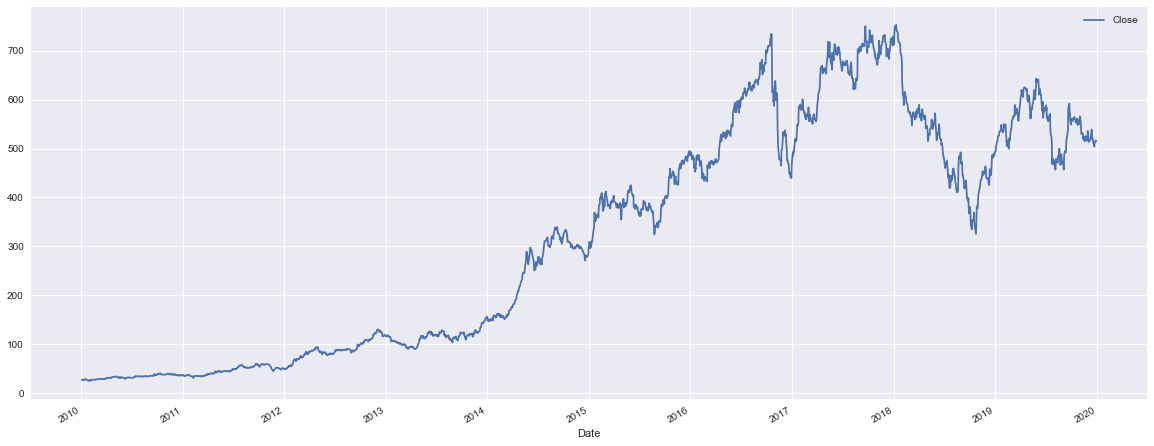

In [7]:
df.plot(figsize=(20,8))
plt.show()

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

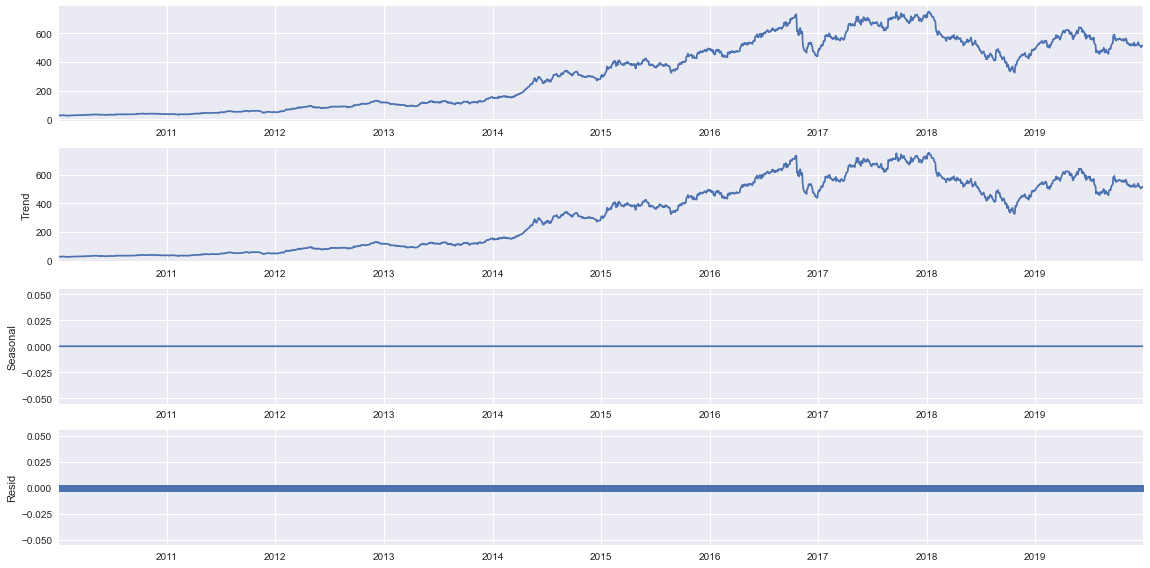

In [9]:
# Change default figsize
plt.rc("figure",figsize=(16,8))
seasonal_decompose(df,model='additive',freq=1).plot();


### Train test split

In [10]:
df.head()

,Close
Date,
2010-01-04,27.000000
2010-01-05,27.125000
2010-01-06,26.825001
2010-01-07,27.100000
2010-01-08,26.700001


In [11]:
# Train data = 90%, Test data = 10%
train_range = math.floor(len(df.index)*.9)
test_range = math.floor(len(df.index)*.1)

# Train DataFrame
train_df = df.Close[:train_range].sort_index()

# Test DataFrame
test_df = df.Close[train_range:].sort_index()

In [12]:
print(len(train_df))
print(len(test_df))

2214
246


In [13]:
test_df = test_df[38:238]

### Holt-Winters model

In [14]:
hwmodel=ExponentialSmoothing(train_df,trend='add', seasonal=None).fit()

In [15]:
print(hwmodel.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                 2214
Model:             ExponentialSmoothing   SSE                         103073.449
Optimized:                         True   AIC                           8511.179
Trend:                         Additive   BIC                           8533.989
Seasonal:                          None   AICC                          8511.217
Seasonal Periods:                  None   Date:                 Sun, 10 Apr 2022
Box-Cox:                          False   Time:                         18:17:21
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950025                alpha                 True
smoothing_trend            0.00012

In [16]:
step=200

In [17]:
test_pred=hwmodel.forecast(step)

In [18]:
test_pred = test_pred.to_list()

In [19]:
test_pred = pd.Series(test_pred, index=test_df[:step].index)

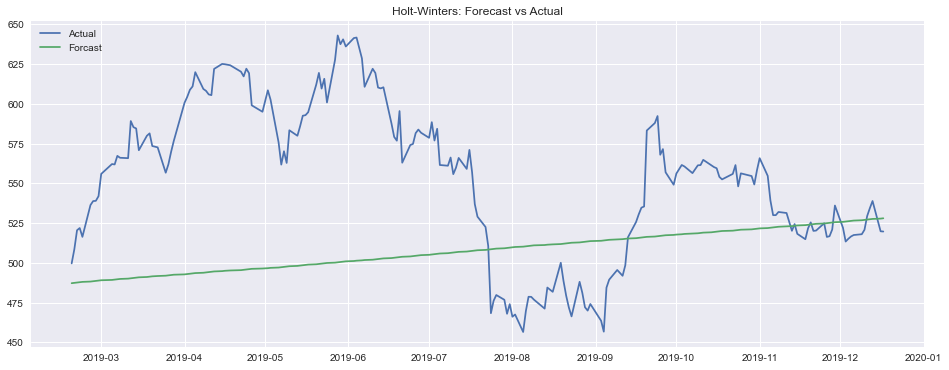

In [26]:
plt.figure(figsize=(16, 6))
plt.plot(test_df[:step], label='Actual')
plt.plot(test_pred, label='Forcast')
plt.title('Holt-Winters: Forecast vs Actual')
plt.legend(loc='upper left')
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# report performance
mse = mean_squared_error(test_df[:step], test_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_df[:step], test_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_df[:step], test_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_pred - test_df[:step])/np.abs(test_df[:step]))
print('MAPE: '+str(mape))

MSE: 4947.9719472464585
MAE: 58.107898052961424
RMSE: 70.3418221774675
MAPE: 0.10097264763207876


In [22]:
# % Growth in actual data 
round((test_df.iloc[-1] - test_df.iloc[0]) / test_df.iloc[0] * 100, 2)

4.01

In [23]:
# % Prediction difference 
round((test_df.iloc[-1] - test_pred[-1]) / test_pred[-1] *100, 2)

-1.58